In [7]:
import os
import json
import cv2

# Define directories
label_dir = "/data/ephemeral/home/MCG/train/outputs_json"
input_dir = "/data/ephemeral/home/MCG/train/DCM"
output_dir = "/data/ephemeral/home/MCG/train/annotated_images"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Calculate bounding box for a set of points
def calculate_bounding_box(points):
    if not points:
        return None
    x_values = [p[0] for p in points]
    y_values = [p[1] for p in points]
    return min(x_values), min(y_values), max(x_values), max(y_values)

# Process each patient's images
for patient_id in os.listdir(label_dir):
    patient_label_path = os.path.join(label_dir, patient_id)
    patient_image_path = os.path.join(input_dir, patient_id)
    
    if not os.path.isdir(patient_label_path):
        continue

    for json_file in os.listdir(patient_label_path):
        if json_file.endswith(".json"):
            # Load JSON data
            json_path = os.path.join(patient_label_path, json_file)
            with open(json_path, "r") as f:
                data = json.load(f)

            # Prepare image path and output path
            image_name = json_file.replace(".json", ".png")
            image_path = os.path.join(patient_image_path, image_name)
            output_path = os.path.join(output_dir, f"{patient_id}_{image_name}")
            
            # Skip if the corresponding image does not exist
            if not os.path.isfile(image_path):
                continue

            # Read the image using OpenCV
            image = cv2.imread(image_path)
            if image is None:
                continue

            # Initialize groups
            finger_points = []
            radius_ulna_points = []
            others_points = []

            # Categorize points based on labels
            for annotation in data['annotations']:
                label = annotation['label']
                points = annotation['points']
                
                if 'finger' in label.lower():
                    finger_points.extend(points)
                elif label in ['Radius', 'Ulna']:
                    radius_ulna_points.extend(points)
                else:
                    others_points.extend(points)

            # Calculate bounding boxes for each group
            finger_box = calculate_bounding_box(finger_points)
            radius_ulna_box = calculate_bounding_box(radius_ulna_points)
            others_box = calculate_bounding_box(others_points)

            # Draw bounding boxes on the image
            if finger_box is not None:
                x_min, y_min, x_max, y_max = finger_box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blue for Fingers
            if radius_ulna_box is not None:
                x_min, y_min, x_max, y_max = radius_ulna_box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green for Radius & Ulna
            if others_box is not None:
                x_min, y_min, x_max, y_max = others_box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  # Red for Others

            # Save the annotated image
            cv2.imwrite(output_path, image)


In [11]:
import os
import json
import cv2
import shutil

# Define directories
label_dir = "/data/ephemeral/home/MCG/train/outputs_json"
input_dir = "/data/ephemeral/home/MCG/train/DCM"
output_dir = "/data/ephemeral/home/MCG/train/yolo_annotations"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Calculate bounding box for a set of points
def calculate_bounding_box(points):
    if not points:
        return None
    x_values = [p[0] for p in points]
    y_values = [p[1] for p in points]
    return min(x_values), min(y_values), max(x_values), max(y_values)

# Normalize bounding box to YOLO format
def normalize_bbox(image_shape, bbox):
    if bbox is None:
        return None
    height, width = image_shape[:2]
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2 / width
    y_center = (y_min + y_max) / 2 / height
    box_width = (x_max - x_min) / width
    box_height = (y_max - y_min) / height
    return x_center, y_center, box_width, box_height

# Define class mappings
class_map = {
    "finger": 0,
    "radius_ulna": 1,
    "others": 2
}

# Process each patient's images
for patient_id in os.listdir(label_dir):
    patient_label_path = os.path.join(label_dir, patient_id)
    patient_image_path = os.path.join(input_dir, patient_id)
    
    if not os.path.isdir(patient_label_path):
        continue

    for json_file in os.listdir(patient_label_path):
        if json_file.endswith(".json"):
            # Load JSON data
            json_path = os.path.join(patient_label_path, json_file)
            with open(json_path, "r") as f:
                data = json.load(f)

            # Prepare image path
            image_name = json_file.replace(".json", ".png")
            image_path = os.path.join(patient_image_path, image_name)
            
            # Skip if the corresponding image does not exist
            if not os.path.isfile(image_path):
                continue

            # Read the image to get dimensions
            image = cv2.imread(image_path)
            if image is None:
                continue

            # Initialize groups
            finger_points = []
            radius_ulna_points = []
            others_points = []

            # Categorize points based on labels
            for annotation in data['annotations']:
                label = annotation['label']
                points = annotation['points']
                
                if 'finger' in label.lower():
                    finger_points.extend(points)
                elif label in ['Radius', 'Ulna']:
                    radius_ulna_points.extend(points)
                else:
                    others_points.extend(points)

            # Calculate bounding boxes for each group
            finger_box = calculate_bounding_box(finger_points)
            radius_ulna_box = calculate_bounding_box(radius_ulna_points)
            others_box = calculate_bounding_box(others_points)

            # Normalize bounding boxes
            yolo_annotations = []
            if finger_box is not None:
                yolo_annotations.append((class_map["finger"], *normalize_bbox(image.shape, finger_box)))
            if radius_ulna_box is not None:
                yolo_annotations.append((class_map["radius_ulna"], *normalize_bbox(image.shape, radius_ulna_box)))
            if others_box is not None:
                yolo_annotations.append((class_map["others"], *normalize_bbox(image.shape, others_box)))

            # Save YOLO annotation to a text file
            annotation_file = os.path.join(output_dir, f"{patient_id}_{image_name.replace('.png', '.txt')}")
            with open(annotation_file, "w") as f:
                for annotation in yolo_annotations:
                    class_id, x_center, y_center, box_width, box_height = annotation
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")
            
            # Copy the image to the output directory
            output_image_path = os.path.join(output_dir, f"{patient_id}_{image_name}")
            shutil.copy(image_path, output_image_path)

print("Annotations and images have been successfully processed and saved in YOLO format.")


Annotations and images have been successfully processed and saved in YOLO format.


In [13]:
import os
import shutil
import random

# Directories
yolo_annotations_dir = "/data/ephemeral/home/MCG/train/yolo_annotations"
train_dir = "/data/ephemeral/home/MCG/train/yolo_dataset/train"
valid_dir = "/data/ephemeral/home/MCG/train/yolo_dataset/valid"

# Create directories for train and validation sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Group annotation files by patient ID
annotation_files = [
    os.path.join(yolo_annotations_dir, file)
    for file in os.listdir(yolo_annotations_dir)
    if file.endswith(".txt")
]

# Group files by patient ID
patient_groups = {}
for file in annotation_files:
    patient_id = os.path.basename(file).split('_')[0]  # Extract patient ID (e.g., "ID001")
    if patient_id not in patient_groups:
        patient_groups[patient_id] = []
    patient_groups[patient_id].append(file)

# Shuffle patient IDs
patient_ids = list(patient_groups.keys())
random.shuffle(patient_ids)

# Split patient IDs into train (85%) and valid (15%)
split_index = int(len(patient_ids) * 0.85)
train_patient_ids = patient_ids[:split_index]
valid_patient_ids = patient_ids[split_index:]

# Collect files for train and valid
train_files = [file for pid in train_patient_ids for file in patient_groups[pid]]
valid_files = [file for pid in valid_patient_ids for file in patient_groups[pid]]

# Helper function to move files
def move_files(file_list, target_dir):
    for file in file_list:
        # Move annotation file
        shutil.copy(file, os.path.join(target_dir, os.path.basename(file)))
        
        # Move the corresponding image file
        image_file = file.replace(".txt", ".png")
        if os.path.isfile(image_file):
            shutil.copy(image_file, os.path.join(target_dir, os.path.basename(image_file)))

# Move files to respective directories
move_files(train_files, train_dir)
move_files(valid_files, valid_dir)

print(f"Train and validation datasets created.")
print(f"Train files: {len(train_files)}, Validation files: {len(valid_files)}")


Train and validation datasets created.
Train files: 680, Validation files: 120


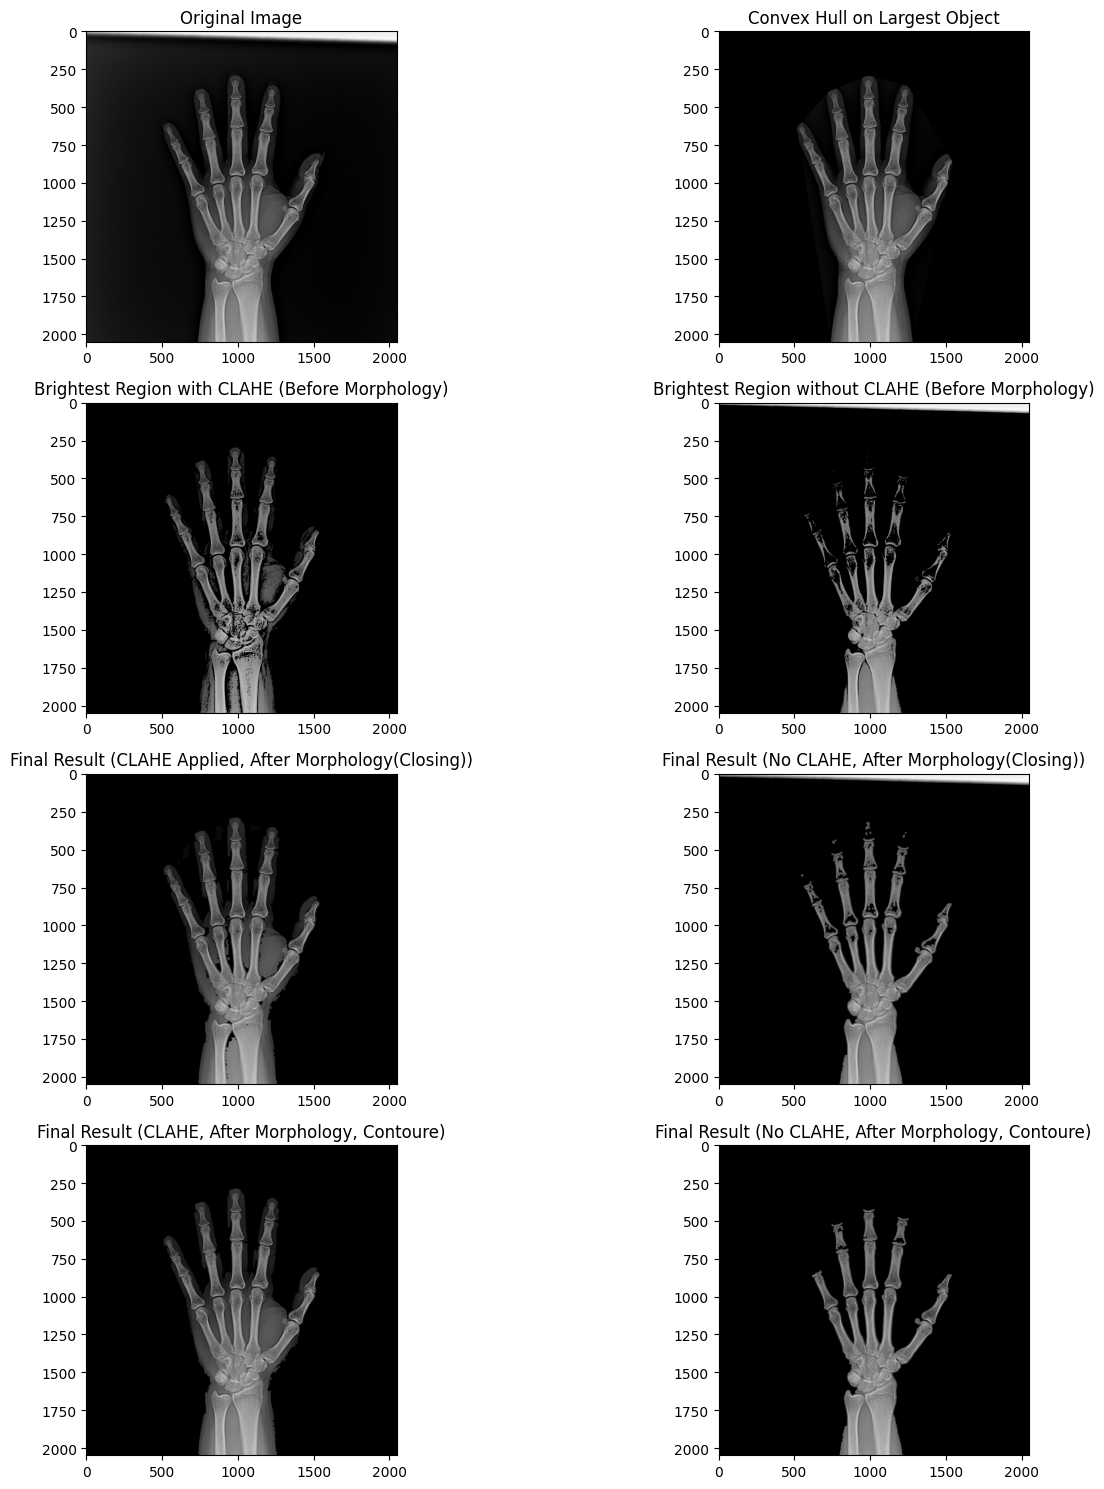

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from scipy import ndimage  # scipy.ndimage 모듈 임포트

# 이미지 경로 설정
image_path = "/data/ephemeral/home/MCG/train/DCM/ID020/image1661221262696.png"

# 이미지 읽기 및 그레이스케일 변환
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 이진화하여 객체 추출 (임계값 조정)
_, binary = cv2.threshold(gray_image, 45, 255, cv2.THRESH_BINARY)

# 작은 노이즈 제거
kernel = np.ones((8, 8), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# 외곽선(윤곽선) 찾기
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 가장 큰 윤곽선 찾기
largest_contour = max(contours, key=cv2.contourArea)

# 컨벡스 헐 찾기
hull = cv2.convexHull(largest_contour)

# 빈 마스크에 컨벡스 헐을 그림
convex_hull_mask = np.zeros_like(gray_image)
cv2.drawContours(convex_hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

# Convex Hull 마스크를 원본 이미지에 적용하여 배경 제거
image_with_hull = cv2.bitwise_and(image, image, mask=convex_hull_mask)

# CLAHE 적용 (멀티 오츠 직전에 적용)
clahe = cv2.createCLAHE(clipLimit=8, tileGridSize=(26, 26))
enhanced_image = clahe.apply(cv2.cvtColor(image_with_hull, cv2.COLOR_BGR2GRAY))

# Multi-Otsu thresholding - CLAHE 적용 후
thresholds = filters.threshold_multiotsu(enhanced_image, classes=4)
brightest_region_mask_clahe = (enhanced_image > thresholds[-2]).astype(np.uint8)

# Multi-Otsu thresholding - CLAHE 미적용
thresholds_no_clahe = filters.threshold_multiotsu(gray_image, classes=4)
brightest_region_mask_no_clahe = (gray_image > thresholds_no_clahe[-2]).astype(np.uint8)

# 모폴로지와 Fill Hole 전 이미지
initial_result_clahe = cv2.bitwise_and(image, image, mask=brightest_region_mask_clahe * 255)
initial_result_no_clahe = cv2.bitwise_and(image, image, mask=brightest_region_mask_no_clahe * 255)

# 모폴로지 연산 및 내부 구멍 채우기
#kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))
kernel_delite_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))
kernel_erode_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
# CLAHE 적용 후 모폴로지 연산 및 Fill Hole
#closed_mask_clahe = cv2.morphologyEx(brightest_region_mask_clahe, cv2.MORPH_CLOSE, kernel_ellipse)
closed_mask_clahe = cv2.morphologyEx(brightest_region_mask_clahe, cv2.MORPH_DILATE, kernel_delite_ellipse)
closed_mask_clahe = cv2.morphologyEx(closed_mask_clahe, cv2.MORPH_ERODE, kernel_erode_ellipse)
final_result_clahe = cv2.bitwise_and(image, image, mask=closed_mask_clahe * 255)

# CLAHE 미적용 모폴로지 연산 및 Fill Hole
#closed_mask_no_clahe = cv2.morphologyEx(brightest_region_mask_no_clahe, cv2.MORPH_CLOSE, kernel_ellipse)
closed_mask_no_clahe = cv2.morphologyEx(brightest_region_mask_no_clahe, cv2.MORPH_DILATE, kernel_delite_ellipse)
closed_mask_no_clahe = cv2.morphologyEx(closed_mask_no_clahe, cv2.MORPH_ERODE, kernel_erode_ellipse)
final_result_no_clahe = cv2.bitwise_and(image, image, mask=closed_mask_no_clahe * 255)


# 각 최종 결과에서 가장 큰 외곽선만 추출하는 함수
def extract_largest_contour(result_mask):
    contours, _ = cv2.findContours(result_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        contour_mask = np.zeros_like(result_mask)
        cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        return cv2.bitwise_and(image, image, mask=contour_mask)
    return result_mask

# 각각 최종 결과에서 가장 큰 외곽선을 추출하여 결과 이미지 생성
contour_result_clahe = extract_largest_contour(closed_mask_clahe * 255)
contour_result_no_clahe = extract_largest_contour(closed_mask_no_clahe * 255)


# Plot results (3x2 grid)
plt.figure(figsize=(15, 15))

plt.subplot(4, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(4, 2, 2)
plt.title("Convex Hull on Largest Object")
plt.imshow(cv2.cvtColor(image_with_hull, cv2.COLOR_BGR2RGB))

plt.subplot(4, 2, 3)
plt.title("Brightest Region with CLAHE (Before Morphology)")
plt.imshow(cv2.cvtColor(initial_result_clahe, cv2.COLOR_BGR2RGB))

plt.subplot(4, 2, 4)
plt.title("Brightest Region without CLAHE (Before Morphology)")
plt.imshow(cv2.cvtColor(initial_result_no_clahe, cv2.COLOR_BGR2RGB))

plt.subplot(4, 2, 5)
plt.title("Final Result (CLAHE Applied, After Morphology(Closing))")
plt.imshow(cv2.cvtColor(final_result_clahe, cv2.COLOR_BGR2RGB))

plt.subplot(4, 2, 6)
plt.title("Final Result (No CLAHE, After Morphology(Closing))")
plt.imshow(cv2.cvtColor(final_result_no_clahe, cv2.COLOR_BGR2RGB))


plt.subplot(4, 2, 7)
plt.title("Final Result (CLAHE, After Morphology, Contoure)")
plt.imshow(cv2.cvtColor(contour_result_clahe, cv2.COLOR_BGR2RGB))

plt.subplot(4, 2, 8)
plt.title("Final Result (No CLAHE, After Morphology, Contoure)")
plt.imshow(cv2.cvtColor(contour_result_no_clahe, cv2.COLOR_BGR2RGB))


plt.tight_layout()
plt.show()
